# Layer Visualization with Tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf

Applied Calculus with Tensorflow: Let f be a function of x, tf.GradientTape() allows you to record what f does to x. Let's use it to take the derivative of some func f.

In [3]:
x = tf.constant(2.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**3 # f(x)
dy_dx = tape.gradient(y, x) # derivative of y w.r.t. x
print(dy_dx)

tf.Tensor(12.0, shape=(), dtype=float32)


## Face detection with ageitgey/face_recognition

We'll use similar methodology while tackling gradient ascent. Starting with steps shared with gradient descent, we'll then differ in objective and maximize the loss function. Since my trajectory is to talk about manipulation of random noise to observe some feature the network learned, a.k.a. feature visualization by optimisation, we will be focusing on loss function's gradient with respect to input image.

https://github.com/ageitgey/face_recognition

In [4]:
# ! pip3 install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=a5a0065d674c6778f72bcb7abbd2ccf19131979761bc13e658d26bb97c2f0b26
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [19]:
import face_recognition
import PIL
import IPython.display as display

In [6]:
# image = face_recognition.load_image_file("/content/original.jpg")
# face_locations = face_recognition.face_locations(image)

In [8]:
# top, right, bottom, left = face_locations[0]
# face_image = image[top:bottom, left:right]
# pil_image = PIL.Image.fromarray(face_image)

In [9]:
# pil_image.save('face.jpg')

In [ ]:
# ! unzip /content/drive/MyDrive/vggface2_Keras.zip

In [11]:
from keras.models import load_model
import numpy as np

In [31]:
image_path = '/content/face.jpg'

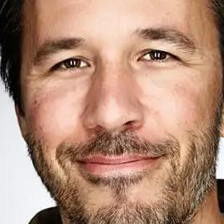

In [34]:
# Download an image and read it into a NumPy array.
def download(max_dim=None):
  # name = url.split('/')[-1]
  # image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(max_dim=224)
show(original_img)

In [35]:
original_img.shape

(224, 224, 3)

## Feature Visualization by optimisation

In [ ]:
# ! git clone https://github.com/WeidiXie/Keras-VGGFace2-ResNet50

fatal: destination path 'Keras-VGGFace2-ResNet50' already exists and is not an empty directory.


In [36]:
base_model = tf.keras.models.load_model('/content/vggface2_Keras/model/resnet50_softmax_dim512/weights.h5') 

In [38]:
names = ['add_5','add_6']
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.models.Model(inputs=base_model.input, outputs=layers)

In [39]:
def calc_loss(img, model):
# Pass forward the image through the model to retrieve the activations.
# Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
    
    return  tf.reduce_sum(losses)

In [40]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [41]:
deepdream = DeepDream(dream_model)

In [42]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

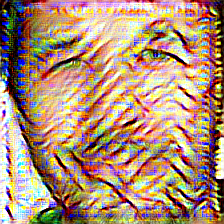

In [43]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)